### Extract text from pdf

In [1]:
from PyPDF2 import PdfReader
import os

In [2]:
pdf = "./PDFs/resNet.pdf"
reader = PdfReader(pdf)

In [40]:
# Extract text from each page and concatenate into a single string
text = ""
for page in range(len(reader.pages)):
    page_text = reader.pages[page].extract_text()
    text += page_text

### Clean text

In [4]:
import re

In [41]:
# Remove citations (text in square brackets)
text = re.sub(r'\[\d+(,\s*\d+)*\]', '', text)

In [42]:
# Remove URLs from the text
text = re.sub(r'https?://\S+', '', text)

In [43]:
# Remove null, newline characters
text = re.sub(r'[\x00-\x1F\x7F-\x9F]', ' ', text)

In [44]:
#Save text
with open("./Texts/text.txt","w",encoding='UTF-8') as f:
    f.write(text)

### Tokenize

In [69]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

import pandas as pd
import matplotlib

In [95]:
#retrieve text from text file
with open('./Texts/text.txt', 'r') as f:
    content = f.read()

In [100]:
# Split the text into sentences
sentences = text.split('. ')

# Get the number of tokens for each sentence
n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

max_tokens=800

In [101]:
chunks = []
tokens_so_far = 0
chunk = ""

# Loop through the sentences and tokens joined together in a tuple
for sentence, token in zip(sentences, n_tokens):

    if token>6: #Avoid small chunks

        if tokens_so_far + token < max_tokens:
            chunk += sentence + ". "
            tokens_so_far += token

        else:
            chunks.append(chunk)
            chunk = sentence
            tokens_so_far = token


<Axes: >

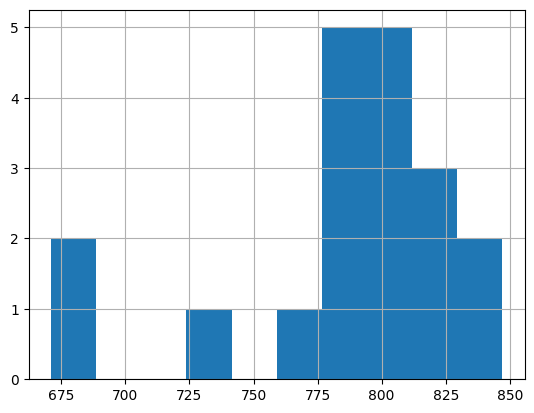

In [102]:
df = pd.DataFrame()
df['text'] = chunks

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

### Embeddings

In [104]:
import openai
from dotenv import load_dotenv

# Load the environment variables from the .env file
load_dotenv()

# Get the value of the API key
openai_api = os.getenv('OPENAI')
openai.api_key=openai_api

In [105]:
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

In [107]:
df.to_csv("embeddings.csv")

In [ ]:
#load embeddings
df = pd.read_csv("embeddings.csv")

### Get distance

In [111]:
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

In [115]:
df['embeddings'] = df['embeddings'].apply(lambda x: np.array(x))
df.head()

,text,n_tokens,embeddings
0,Deep Residual Learning for Image Recognition K...,816,"[0.007473351433873177, -0.000293528864858672, ..."
1,There exists a solution by construction to the...,808,"[-0.004243315197527409, 0.002653388073667884, ..."
2,"For vector quantization, encoding residual vec...",821,"[-0.005247720051556826, 0.019185522571206093, ..."
3,Identity Mapping by Shortcuts We adopt residua...,760,"[-0.011446075513958931, 0.0037446606438606977,..."
4,"37x7 conv, 64, /2 pool, /2 3x3 conv, 64 3x3 co...",789,"[0.012482821010053158, 0.007355828769505024, 0..."


In [124]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [125]:
def answer_question(
    df,
    question,
    model="text-davinci-003",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [133]:
answer_question(df, question="Can you explain the current problem they are addressing. Explain with a paragraph")

'The current problem they are addressing is the degradation problem, which is the phenomenon that when the network depth increases, accuracy gets saturated and then degrades rapidly. This problem is not caused by overfitting, and adding more layers to a suitably deep model leads to higher training error. To address this problem, the authors propose a residual learning framework, which reformulates the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. This reformulation is motivated by the counterintuitive phenomena about the degradation problem, which suggests that the solvers might have difficulties in approximating identity mappings by multiple nonlinear layers. With the residual learning reformulation, if identity mappings are optimal, the solvers may simply drive'